In [35]:
from datetime import datetime
import os
import numpy as np
import pandas as pd
from als import ALSModel
from utils import validation, train, batch_mapk, apk
import pickle
import scipy 
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

In [4]:
import implicit

/Users/sebbyzhao/Library/Caches/pypoetry/virtualenvs/recsys-HtsDc_SN-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
%load_ext autoreload
%autoreload 2

## Data Preprocessing ##

In [ ]:
# Referenced https://github.com/storieswithsiva/Movie-Recommendation-Netflix/blob/master/Uploading%20Movie%20Recommendation%20Netflix.ipynb

In [ ]:
start = datetime.now()
if not os.path.isfile('../data/archive/data.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # reading from each of the four files and appending each rating to a global file 'train.csv'
    data = open('../data/archive/data.csv', mode='w')
    
    row = list()
    files=['../data/archive/combined_data_1.txt','data/archive/combined_data_2.txt', 
           '../data/archive/combined_data_3.txt', 'data/archive/combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:]
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time taken :', datetime.now() - start)

In [ ]:
print("creating the dataframe from data.csv file..")
df = pd.read_csv('../data/archive/data.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
df['id'] = df.index
df

In [ ]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

In [ ]:
# Keep only users who rated at least 20 movies
df = df.groupby("user").filter(lambda x: len(x) >= 20)
len(np.unique(df.user))

In [ ]:
# Create training and validation sets
# Keep 10 random ratings of each user for validation
valid = df.groupby('user').apply(lambda x: x.sample(n=10, random_state=42))

In [ ]:
valid = valid.reset_index(drop=True)
valid

In [ ]:
train = df[~df.id.isin(valid.id)]
train

In [ ]:
train.to_csv('../data/archive/train.csv', index=False, header=False)
valid.to_csv('../data/archive/valid.csv', index=False, header=False)

In [32]:
train = pd.read_csv('../data/archive/train.csv', names=['movie', 'user', 'rating', 'date', 'id'])
valid = pd.read_csv('../data/archive/valid.csv', names=['movie', 'user', 'rating', 'date', 'id'])

In [ ]:
valid.head()

In [ ]:
# This is way too large to do calculations on. Let's reduce to 1000 users.

In [33]:
users = np.random.choice(valid['user'].unique(), size=1000, replace=False)

In [34]:
train[train['user'].isin(users)].to_csv('../data/archive/train_1000.csv', index=False, header=False)
valid[valid['user'].isin(users)].to_csv('../data/archive/valid_1000.csv', index=False, header=False)

## Script Proper ##

In [87]:
train_data = pd.read_csv('../data/archive/train_1000.csv', names=['movie', 'user', 'rating', 'date', 'id'])
valid_data = pd.read_csv('../data/archive/valid_1000.csv', names=['movie', 'user', 'rating', 'date', 'id'])

In [88]:
valid_data

,movie,user,rating,date,id
0,14218,609,3,2005-05-04,78270268
1,15578,609,3,2005-05-04,87689076
2,15393,609,4,2005-05-04,86457259
3,6994,609,4,2005-05-04,39647242
4,3274,609,1,2005-05-04,16868285
...,...,...,...,...,...
9995,13103,2646451,4,2004-01-22,72683585
9996,1180,2646451,4,2004-02-11,6042131
9997,516,2646451,4,2004-11-09,2837387
9998,3293,2646451,2,2005-04-28,17115028


In [89]:
guarantee_items = pd.concat([pd.DataFrame([[i, -1, -1, -1, -1]], columns=['movie', 'user', 'rating', 'date', 'id']) for i in np.unique(np.append(train_data['movie'].unique(), valid_data['movie'].unique()))],ignore_index=True)
guarantee_items

,movie,user,rating,date,id
0,2,-1,-1,-1,-1
1,3,-1,-1,-1,-1
2,5,-1,-1,-1,-1
3,6,-1,-1,-1,-1
4,8,-1,-1,-1,-1
...,...,...,...,...,...
11571,17763,-1,-1,-1,-1
11572,17764,-1,-1,-1,-1
11573,17768,-1,-1,-1,-1
11574,17769,-1,-1,-1,-1


In [90]:
train_data = pd.concat([train_data, guarantee_items], ignore_index=True)
train_data.head()

,movie,user,rating,date,id
0,2,2345723,4,2004-12-26,658
1,3,360757,3,2005-10-21,1620
2,3,414236,4,2005-10-11,1901
3,3,1187765,4,2003-05-07,2033
4,3,524628,4,2003-03-13,2043


In [91]:
valid_data = pd.concat([valid_data, guarantee_items], ignore_index=True)
valid_data.head()

,movie,user,rating,date,id
0,14218,609,3,2005-05-04,78270268
1,15578,609,3,2005-05-04,87689076
2,15393,609,4,2005-05-04,86457259
3,6994,609,4,2005-05-04,39647242
4,3274,609,1,2005-05-04,16868285


In [92]:
# Create watch matrix
watch_matrix = pd.pivot_table(data=train_data, index='user', columns='movie', values='rating', fill_value=0)
watch_matrix = watch_matrix.applymap(lambda x: 1 if x > 0 else 0)
watch_matrix = watch_matrix.drop(-1, axis=0)
watch_matrix

movie,2,3,5,6,8,12,13,15,16,17,...,17758,17759,17760,17761,17762,17763,17764,17768,17769,17770
user,,,,,,,,,,,,,,,,,,,,,
609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
13839,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2643191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2643233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2644283,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
np.sum(watch_matrix.values > 0)

214384

In [12]:
# Watch matrix validation
watch_matrix_validation = pd.pivot_table(data=valid_data, index='user', columns='movie', values='rating', fill_value=0)
watch_matrix_validation = watch_matrix_validation.applymap(lambda x: 1 if x > 0 else 0)
watch_matrix_validation = watch_matrix_validation.drop(-1, axis=0)
watch_matrix_validation

movie,2,3,5,6,8,12,13,15,16,17,...,17758,17759,17760,17761,17762,17763,17764,17768,17769,17770
user,,,,,,,,,,,,,,,,,,,,,
609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13839,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2643191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2643233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2644283,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
def random_classification_noise(watch_matrix, p):
    """
    watch_matrix: watch matrix of watched or not
    p: probability of disliking an interacted with item
    """
    # Create a copy of the watch matrix
    watch_matrix_noisy = watch_matrix.copy()
    
    # For each user, randomly select p% of their interacted with items and set them to 0
    watch_matrix_noisy = watch_matrix_noisy.applymap(lambda x: -1 if x == 1 and np.random.random() < p else x)

    return watch_matrix_noisy.values

In [14]:
# Generate preference matrix based on simulation for validation dataset.
# Start training for 20 epochs

In [15]:
random_classification_noise(watch_matrix_validation, 0.1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [16]:
watch_matrix_validation.values.shape

(1000, 11576)

In [17]:
watch_matrix.values.shape

(1000, 11576)

In [18]:
watch_matrix_csr = scipy.sparse.csr_matrix(watch_matrix.values)

In [19]:
def convert_to_index_lst(matrix):
    return [list(np.where(row == 1)[0]) for row in matrix]

In [20]:
true_prefs = convert_to_index_lst(random_classification_noise(watch_matrix_validation, 0.1))

In [21]:
proxy_prefs = convert_to_index_lst(watch_matrix_validation.values)

In [26]:
proxy_losses, true_losses = [], []
def validation_hook(solver, epoch, elapsed_time, progress):
    recommendations = solver.recommend(np.arange(solver.user_factors.shape[0]), watch_matrix_csr, filter_already_liked_items=True, N=10)[0]
    #FIXME: This should actually be the indices of the items

    # PROXY PREFS AND TRUE PREFS MUST BE A LISt OF INDEXES
    global proxy_prefs
    global true_prefs
    proxy_loss, true_loss = batch_mapk(recommendations, proxy_prefs, true_prefs)
    proxy_losses.append(proxy_loss)
    true_losses.append(true_loss)
    # Calculate validation loss
    

In [24]:
model = implicit.als.AlternatingLeastSquares(factors=100, calculate_training_loss=True, iterations=10)
model.fit(watch_matrix_csr, callback=validation_hook)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:11,  1.26s/it, loss=0.00997]

(0.04545674603174612, 0.04328965183295554)


 20%|██        | 2/10 [00:03<00:11,  1.44s/it, loss=0.00794]

(0.06784817460317451, 0.06480547351347954)


 30%|███       | 3/10 [00:04<00:10,  1.52s/it, loss=0.00741]

(0.07453206349206343, 0.07140604072184444)


 40%|████      | 4/10 [00:06<00:09,  1.56s/it, loss=0.00722]

(0.07576313492063493, 0.07314631456286225)


 50%|█████     | 5/10 [00:08<00:07,  1.60s/it, loss=0.00712]

(0.07565781746031744, 0.07319750692869759)


 60%|██████    | 6/10 [00:09<00:06,  1.61s/it, loss=0.00707]

(0.07641436507936511, 0.07399812074829948)


 70%|███████   | 7/10 [00:11<00:04,  1.61s/it, loss=0.00704]

(0.07690027777777789, 0.07431503511589835)


 80%|████████  | 8/10 [00:12<00:03,  1.60s/it, loss=0.00702]

(0.07705916666666669, 0.07431539887251208)


 90%|█████████ | 9/10 [00:14<00:01,  1.62s/it, loss=0.00701]

(0.07728396825396824, 0.07463593726379444)


100%|██████████| 10/10 [00:16<00:00,  1.65s/it, loss=0.007]  

(0.07733174603174606, 0.07437612244897969)


[0.009969112783726319,
 0.007939922529638859,
 0.007413441399472809,
 0.007219799514104095,
 0.007123782633020261,
 0.007070842644408495,
 0.007040110278585718,
 0.007021102617544681,
 0.0070085848854418275,
 0.006999884910068832]

In [36]:
res = []

for p in [0.25, 0.5, 0.75]:
    proxy_losses = []
    true_losses = []
    true_prefs = convert_to_index_lst(random_classification_noise(watch_matrix_validation, p))
    
    model = implicit.als.AlternatingLeastSquares(factors=100, calculate_training_loss=True, iterations=100)
    train_losses = model.fit(watch_matrix_csr, callback=validation_hook)
    res.append((p, train_losses, proxy_losses, true_losses))

with open('../data/archive/results.txt', 'wb') as f:
    pickle.dump(res, f)


100%|██████████| 100/100 [02:48<00:00,  1.69s/it, loss=0.00696]


Text(0, 0.5, 'MAP@K')

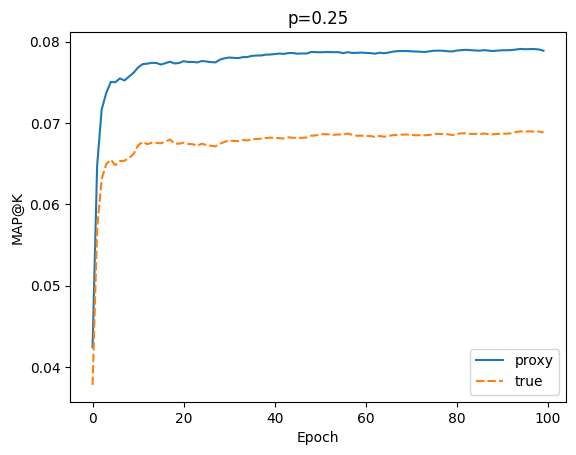

In [51]:
p, train_losses, proxy_losses, true_losses = res[0]
df = pd.DataFrame({'proxy': proxy_losses, 'true': true_losses})
sns.lineplot(data=df)
plt.title(f"p={p}")
plt.xlabel("Epoch")
plt.ylabel("MAP@K")


Text(0, 0.5, 'MAP@K')

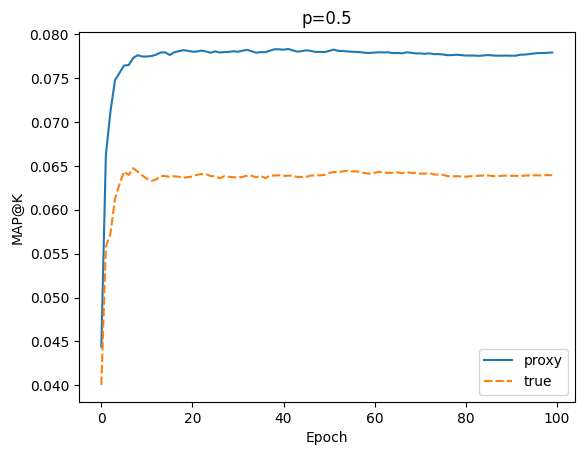

In [47]:
p, train_losses, proxy_losses, true_losses = res[1]
df = pd.DataFrame({'proxy': proxy_losses, 'true': true_losses})
sns.lineplot(data=df)
plt.title(f"p={p}")
plt.xlabel("Epoch")
plt.ylabel("MAP@K")


Text(0, 0.5, 'MAP@K')

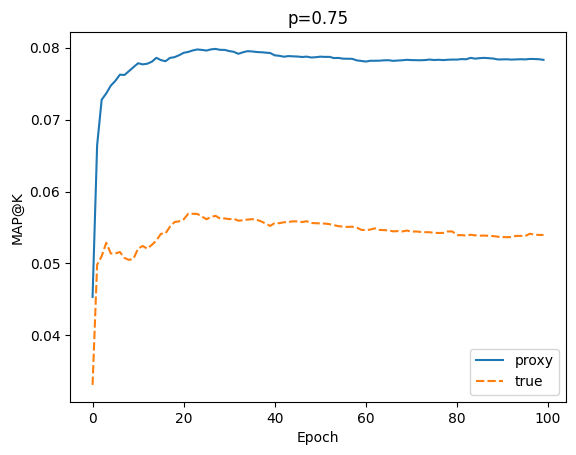

In [48]:
p, train_losses, proxy_losses, true_losses = res[2]
df = pd.DataFrame({'proxy': proxy_losses, 'true': true_losses})
sns.lineplot(data=df)
plt.title(f"p={p}")
plt.xlabel("Epoch")
plt.ylabel("MAP@K")



In [49]:
proxy_losses = []
true_losses = []
true_prefs = convert_to_index_lst(random_classification_noise(watch_matrix_validation, 0.9))

model = implicit.als.AlternatingLeastSquares(factors=100, calculate_training_loss=True, iterations=100)
train_losses = model.fit(watch_matrix_csr, callback=validation_hook)

100%|██████████| 100/100 [02:49<00:00,  1.69s/it, loss=0.00696]


Text(0, 0.5, 'MAP@K')

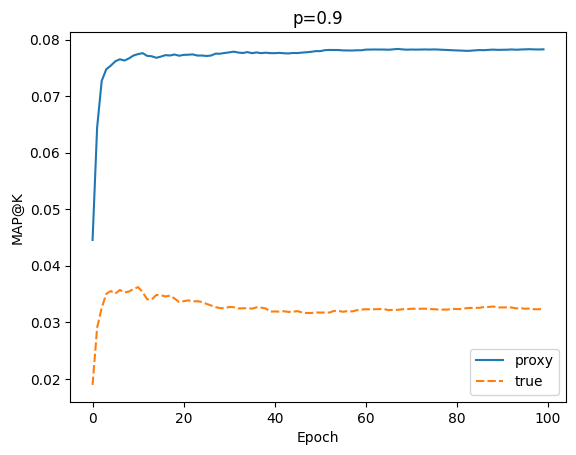

In [50]:
df = pd.DataFrame({'proxy': proxy_losses, 'true': true_losses})
sns.lineplot(data=df)
plt.title(f"p={0.9}")
plt.xlabel("Epoch")
plt.ylabel("MAP@K")

## Simulated Data ##

In [6]:
def simulate_data(num_users, num_items, num_factors):
    users = np.random.randn(num_users, num_factors)
    items = np.random.randn(num_items, num_factors)

    user_item = users @ items.T
    return user_item


In [7]:
simulated_data = simulate_data(1000, 10000, 100)

In [8]:
simulated_data

array([[  4.65923124,  -7.04281911, -14.02428897, ...,  -4.1117815 ,
         22.31884651,   6.0312735 ],
       [ -7.07037796,  -6.12756016,   4.22028879, ...,   9.26579467,
         -8.9955523 ,  10.22576638],
       [ -2.50564653, -10.67149678,  -0.18220163, ...,  -2.58258075,
         11.47698931,  -5.555297  ],
       ...,
       [ 19.51083316, -20.19429301,   9.99380545, ...,  -4.11038816,
          4.7400323 ,   9.13787008],
       [ -8.27739493,   2.02767866,   2.93065063, ..., -14.62498386,
         12.51977849, -12.69098144],
       [ -1.40988881,   2.57418801,  14.78149743, ...,   4.83398384,
          5.90378436,  -0.26404195]])

In [9]:
ratings = 1000 * 10000

In [10]:
(simulated_data > 20).sum() 

231788

In [11]:
(simulated_data > 22).sum()

144222

In [12]:
(simulated_data > 24).sum()

86625

In [13]:
(simulated_data > 26).sum() 

50383

In [14]:
(simulated_data > 28).sum() 

28425

In [15]:
watch_matrix_full = (simulated_data > 20).astype(int)

In [16]:
true_matrix_validation = [(simulated_data > 22).astype(int), (simulated_data > 24).astype(int), (simulated_data > 26).astype(int), (simulated_data > 28).astype(int)]

In [17]:
proxy_prefs = np.zeros(watch_matrix_full.shape)
watch_matrix = watch_matrix_full.copy()
for i in range(watch_matrix_full.shape[0]):
    validation_indices = np.random.choice(np.where(watch_matrix_full[i] == 1)[0], size=10, replace=False)
    proxy_prefs[i][validation_indices] = 1
    watch_matrix[i][validation_indices] = 0

    mask = np.ones(watch_matrix_full[i].shape, dtype=bool)
    mask[validation_indices] = False
    for true_matrix in true_matrix_validation:
        true_matrix[i][mask] = 0

In [20]:
true_prefs_lst = [convert_to_index_lst(true_matrix_validation[i]) for i in range(len(true_matrix_validation))]
proxy_prefs = convert_to_index_lst(proxy_prefs)

In [40]:
popular_recommendations = np.argsort(np.sum(watch_matrix, axis=0))[::-1][:10]
proxy_obj_baseline = batch_mapk(np.tile(popular_recommendations, (watch_matrix.shape[0], 1)), proxy_prefs, true_prefs_lst[0])[0]
true_obj_baseline = batch_mapk(np.tile(popular_recommendations, (watch_matrix.shape[0], 1)), proxy_prefs, true_prefs_lst[0])[1]
proxy_obj_baseline, true_obj_baseline

(0.000525952380952381, 0.0008115608465608467)

In [21]:
np.array_equal(watch_matrix + proxy_prefs, watch_matrix_full)

ValueError: operands could not be broadcast together with shapes (1000,10000) (1000,10) 

In [264]:
assert watch_matrix.sum() + proxy_prefs.sum() == watch_matrix_full.sum()

In [22]:
watch_matrix_csr = scipy.sparse.csr_matrix(watch_matrix)

In [23]:
proxy_losses, true_losses = [], []
def validation_hook(solver, epoch, elapsed_time, progress):
    recommendations = solver.recommend(np.arange(solver.user_factors.shape[0]), watch_matrix_csr, filter_already_liked_items=True, N=10)[0]
    #FIXME: This should actually be the indices of the items
    global proxy_prefs
    global true_prefs
    proxy_loss, true_loss = batch_mapk(recommendations, proxy_prefs, true_prefs)
    proxy_losses.append(proxy_loss)
    true_losses.append(true_loss)
    print(proxy_loss, true_loss)
    # Calculate validation loss
    

In [25]:
res = []

for true_matrix in true_prefs_lst:
    true_prefs = true_matrix
    proxy_losses = []
    true_losses = []
    model = implicit.als.AlternatingLeastSquares(factors=100, calculate_training_loss=True, iterations=100)
    train_losses = model.fit(watch_matrix_csr, callback=validation_hook)
    res.append((train_losses, proxy_losses, true_losses))

with open('../data/archive/netflix_simulated', 'wb') as f:
    pickle.dump(res, f)


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:01<02:02,  1.23s/it, loss=0.0187]

0.0012157936507936511 0.0016244094860166287


  2%|▏         | 2/100 [00:03<02:25,  1.49s/it, loss=0.0173]

0.005144682539682537 0.006308638983371126


  3%|▎         | 3/100 [00:04<02:28,  1.53s/it, loss=0.0166]

0.00947972222222221 0.012063620086923658


  4%|▍         | 4/100 [00:06<02:28,  1.55s/it, loss=0.0163]

0.012143293650793634 0.015025075585789872


  5%|▌         | 5/100 [00:07<02:27,  1.55s/it, loss=0.0162]

0.01339769841269841 0.017142164745527832


  6%|▌         | 6/100 [00:09<02:29,  1.59s/it, loss=0.0161]

0.01410107142857142 0.01832018927941548


  7%|▋         | 7/100 [00:11<02:26,  1.58s/it, loss=0.0161]

0.01505376984126983 0.01994233119173596


  8%|▊         | 8/100 [00:12<02:24,  1.57s/it, loss=0.0161]

0.015542579365079363 0.02083452333711262


  9%|▉         | 9/100 [00:14<02:23,  1.57s/it, loss=0.0161]

0.015895634920634914 0.021742739355001248


 10%|█         | 10/100 [00:15<02:20,  1.57s/it, loss=0.016] 

0.01609547619047618 0.02213440302973041


 11%|█         | 11/100 [00:17<02:18,  1.56s/it, loss=0.016]

0.016451746031746026 0.022583550327538417


 12%|█▏        | 12/100 [00:19<02:20,  1.60s/it, loss=0.016]

0.01675154761904762 0.022784560185185165


 13%|█▎        | 13/100 [00:20<02:21,  1.63s/it, loss=0.016]

0.016749801587301587 0.02286181185437137


 14%|█▍        | 14/100 [00:22<02:20,  1.63s/it, loss=0.016]

0.016973452380952384 0.023281146699420517


 15%|█▌        | 15/100 [00:23<02:16,  1.61s/it, loss=0.016]

0.01724452380952382 0.02386664698286723


 16%|█▌        | 16/100 [00:25<02:13,  1.58s/it, loss=0.016]

0.017586626984126996 0.024375710663895194


 17%|█▋        | 17/100 [00:26<02:09,  1.56s/it, loss=0.016]

0.017773968253968268 0.02460962695263291


 18%|█▊        | 18/100 [00:28<02:08,  1.57s/it, loss=0.016]

0.01783543650793653 0.02484003511589821


 19%|█▉        | 19/100 [00:30<02:18,  1.71s/it, loss=0.016]

0.01781753968253971 0.024812271510456042


 20%|██        | 20/100 [00:32<02:13,  1.67s/it, loss=0.016]

0.018083293650793683 0.02529849804736711


 21%|██        | 21/100 [00:33<02:09,  1.64s/it, loss=0.016]

0.018181666666666697 0.02535715624212649


 22%|██▏       | 22/100 [00:35<02:08,  1.65s/it, loss=0.016]

0.018230277777777804 0.025408000755857908


 23%|██▎       | 23/100 [00:37<02:05,  1.63s/it, loss=0.016]

0.01833738095238098 0.02556812137818092


 24%|██▍       | 24/100 [00:38<02:03,  1.63s/it, loss=0.016]

0.01827404761904764 0.025493256645250713


 25%|██▌       | 25/100 [00:40<02:02,  1.63s/it, loss=0.016]

0.018421428571428592 0.02563614307760143


 26%|██▌       | 26/100 [00:41<01:58,  1.61s/it, loss=0.016]

0.018397738095238113 0.02555661548878812


 27%|██▋       | 27/100 [00:43<01:56,  1.60s/it, loss=0.016]

0.018487658730158753 0.025578870779793404


 28%|██▊       | 28/100 [00:44<01:53,  1.57s/it, loss=0.016]

0.01851166666666669 0.0255994428697405


 29%|██▉       | 29/100 [00:46<01:50,  1.56s/it, loss=0.016]

0.018555158730158762 0.02566334278155708


 30%|███       | 30/100 [00:48<01:49,  1.56s/it, loss=0.016]

0.018525357142857166 0.025606465576971545


 31%|███       | 31/100 [00:49<01:47,  1.56s/it, loss=0.016]

0.01851650793650796 0.025577021604938285


 32%|███▏      | 32/100 [00:51<01:48,  1.59s/it, loss=0.016]

0.018608055555555572 0.025707400793650807


 33%|███▎      | 33/100 [00:52<01:45,  1.58s/it, loss=0.016]

0.018567380952380967 0.025644563492063503


 34%|███▍      | 34/100 [00:54<01:43,  1.57s/it, loss=0.016]

0.018598730158730176 0.02564978725749561


 35%|███▌      | 35/100 [00:55<01:43,  1.59s/it, loss=0.016]

0.018486904761904774 0.025424220679012358


 36%|███▌      | 36/100 [00:57<01:41,  1.59s/it, loss=0.016]

0.01832988095238097 0.02518103284832453


 37%|███▋      | 37/100 [00:59<01:39,  1.58s/it, loss=0.016]

0.018357500000000016 0.02535263306248427


 38%|███▊      | 38/100 [01:00<01:37,  1.57s/it, loss=0.016]

0.018390158730158746 0.0253895708931721


 39%|███▉      | 39/100 [01:02<01:35,  1.56s/it, loss=0.016]

0.018427658730158742 0.025463626228269108


 40%|████      | 40/100 [01:03<01:33,  1.55s/it, loss=0.016]

0.018441150793650805 0.02549866732804235


 41%|████      | 41/100 [01:05<01:30,  1.54s/it, loss=0.016]

0.01847500000000001 0.02549106623204839


 42%|████▏     | 42/100 [01:06<01:29,  1.54s/it, loss=0.016]

0.018355952380952393 0.025297679988662152


 43%|████▎     | 43/100 [01:08<01:28,  1.55s/it, loss=0.016]

0.01838039682539684 0.02535671721466367


 44%|████▍     | 44/100 [01:09<01:26,  1.55s/it, loss=0.016]

0.01840246031746033 0.025360822467876066


 45%|████▌     | 45/100 [01:11<01:24,  1.54s/it, loss=0.016]

0.018388730158730174 0.025319396730914618


 46%|████▌     | 46/100 [01:13<01:24,  1.56s/it, loss=0.016]

0.01840146825396827 0.02533608465608468


 47%|████▋     | 47/100 [01:14<01:25,  1.61s/it, loss=0.016]

0.018408333333333356 0.025311968065003805


 48%|████▊     | 48/100 [01:16<01:22,  1.59s/it, loss=0.016]

0.018416666666666692 0.02530149187452761


 49%|████▉     | 49/100 [01:17<01:19,  1.57s/it, loss=0.016]

0.018324126984127012 0.025183814090451024


 50%|█████     | 50/100 [01:19<01:17,  1.55s/it, loss=0.016]

0.018268214285714308 0.02510852969891663


 51%|█████     | 51/100 [01:20<01:16,  1.56s/it, loss=0.016]

0.01830805555555558 0.025157904698916624


 52%|█████▏    | 52/100 [01:22<01:14,  1.56s/it, loss=0.016]

0.018276349206349227 0.025091588561350485


 53%|█████▎    | 53/100 [01:24<01:14,  1.59s/it, loss=0.016]

0.01826289682539685 0.02505804358780551


 54%|█████▍    | 54/100 [01:25<01:13,  1.60s/it, loss=0.016]

0.01830226190476193 0.025097674319727904


 55%|█████▌    | 55/100 [01:27<01:11,  1.59s/it, loss=0.016]

0.018311031746031773 0.025107977922650564


 56%|█████▌    | 56/100 [01:28<01:08,  1.57s/it, loss=0.016]

0.0183021031746032 0.025086187484252984


 57%|█████▋    | 57/100 [01:30<01:07,  1.58s/it, loss=0.016]

0.018264960317460346 0.02504445137314187


 58%|█████▊    | 58/100 [01:31<01:05,  1.57s/it, loss=0.016]

0.018267896825396857 0.0250416735953641


 59%|█████▉    | 59/100 [01:33<01:04,  1.58s/it, loss=0.016]

0.01829202380952384 0.02508214978584029


 60%|██████    | 60/100 [01:35<01:04,  1.62s/it, loss=0.016]

0.01828496031746035 0.025131455341395843


 61%|██████    | 61/100 [01:36<01:02,  1.60s/it, loss=0.016]

0.018303412698412735 0.025146841773746563


 62%|██████▏   | 62/100 [01:38<01:00,  1.60s/it, loss=0.016]

0.01831496031746035 0.025221874842529628


 63%|██████▎   | 63/100 [01:40<01:00,  1.63s/it, loss=0.016]

0.01824658730158733 0.025108801650289763


 64%|██████▍   | 64/100 [01:41<00:57,  1.60s/it, loss=0.016]

0.018179166666666698 0.025027313555051667


 65%|██████▌   | 65/100 [01:43<00:55,  1.60s/it, loss=0.016]

0.018173174603174632 0.02502372008062486


 66%|██████▌   | 66/100 [01:44<00:54,  1.60s/it, loss=0.016]

0.01814904761904765 0.024936319286974068


 67%|██████▋   | 67/100 [01:46<00:52,  1.59s/it, loss=0.016]

0.01813305555555559 0.024818314751826675


 68%|██████▊   | 68/100 [01:48<00:50,  1.58s/it, loss=0.016]

0.018078174603174634 0.0247531078357269


 69%|██████▉   | 69/100 [01:49<00:48,  1.57s/it, loss=0.016]

0.018098015873015908 0.024699228867472934


 70%|███████   | 70/100 [01:51<00:47,  1.57s/it, loss=0.016]

0.018080158730158762 0.024668038391282458


 71%|███████   | 71/100 [01:52<00:45,  1.56s/it, loss=0.016]

0.018061388888888922 0.024643395061728413


 72%|███████▏  | 72/100 [01:54<00:43,  1.55s/it, loss=0.016]

0.018033412698412733 0.024593848576467642


 73%|███████▎  | 73/100 [01:55<00:41,  1.54s/it, loss=0.016]

0.018048968253968293 0.024605505322499385


 74%|███████▍  | 74/100 [01:57<00:40,  1.56s/it, loss=0.016]

0.018045357142857182 0.024622171989166053


 75%|███████▌  | 75/100 [01:58<00:39,  1.57s/it, loss=0.016]

0.018084484126984164 0.024681259290753352


 76%|███████▌  | 76/100 [02:00<00:37,  1.57s/it, loss=0.016]

0.01810047619047623 0.02466140258881332


 77%|███████▋  | 77/100 [02:02<00:35,  1.57s/it, loss=0.016]

0.01807785714285718 0.024627551177878577


 78%|███████▊  | 78/100 [02:03<00:34,  1.56s/it, loss=0.016]

0.01806924603174607 0.024616043241370636


 79%|███████▉  | 79/100 [02:05<00:32,  1.55s/it, loss=0.016]

0.018062420634920674 0.024626563838498382


 80%|████████  | 80/100 [02:06<00:31,  1.55s/it, loss=0.016]

0.018044126984127027 0.0246046775006299


 81%|████████  | 81/100 [02:08<00:29,  1.55s/it, loss=0.016]

0.018054126984127023 0.0246046775006299


 82%|████████▏ | 82/100 [02:09<00:28,  1.57s/it, loss=0.016]

0.0180519047619048 0.024624077853363593


 83%|████████▎ | 83/100 [02:11<00:26,  1.56s/it, loss=0.016]

0.018043730158730193 0.024618224678760414


 84%|████████▍ | 84/100 [02:13<00:28,  1.77s/it, loss=0.016]

0.018004444444444472 0.02455577428193502


 85%|████████▌ | 85/100 [02:15<00:26,  1.76s/it, loss=0.016]

0.01801138888888892 0.024555298091458826


 86%|████████▌ | 86/100 [02:16<00:23,  1.70s/it, loss=0.016]

0.018016111111111142 0.024577079396573467


 87%|████████▋ | 87/100 [02:18<00:21,  1.65s/it, loss=0.016]

0.018046468253968287 0.02460624606324013


 88%|████████▊ | 88/100 [14:33<44:19, 221.65s/it, loss=0.016]

0.018031309523809554 0.02459631550768458


 89%|████████▉ | 89/100 [14:35<28:32, 155.66s/it, loss=0.016]

0.018022738095238123 0.02458288013353492


 90%|█████████ | 90/100 [14:36<18:14, 109.49s/it, loss=0.016]

0.01799817460317463 0.02453469419249183


 91%|█████████ | 91/100 [14:38<11:34, 77.13s/it, loss=0.016] 

0.017992619047619077 0.024527381267321763


 92%|█████████▏| 92/100 [14:40<07:15, 54.48s/it, loss=0.016]

0.01798507936507939 0.024518899124464616


 93%|█████████▎| 93/100 [14:41<04:30, 38.66s/it, loss=0.016]

0.017983888888888914 0.024517935405643763


 94%|█████████▍| 94/100 [14:43<02:45, 27.52s/it, loss=0.016]

0.017985992063492086 0.024510346592340665


 95%|█████████▌| 95/100 [14:44<01:38, 19.73s/it, loss=0.016]

0.017994880952380977 0.024521358497102567


 96%|█████████▌| 96/100 [14:46<00:57, 14.27s/it, loss=0.016]

0.017990158730158762 0.024514475466112393


 97%|█████████▋| 97/100 [16:30<00:31, 10.48s/it, loss=0.016]

0.017942222222222252 0.024507650069286995


 98%|█████████▊| 98/100 [16:32<01:16, 38.48s/it, loss=0.016]

0.017942222222222252 0.024507650069286995


 99%|█████████▉| 99/100 [16:34<00:27, 27.66s/it, loss=0.016]

0.017912539682539714 0.024474770250692886


100%|██████████| 100/100 [16:36<00:00,  9.97s/it, loss=0.016]


0.017936587301587335 0.02450572263164527


  1%|          | 1/100 [00:01<01:58,  1.20s/it, loss=0.0187]

0.0014111904761904763 0.0020499338624338625


  2%|▏         | 2/100 [00:03<02:39,  1.63s/it, loss=0.0173]

0.005047896825396822 0.009178346560846557


  3%|▎         | 3/100 [00:05<03:05,  1.91s/it, loss=0.0166]

0.009365238095238083 0.01596044312169312


  4%|▍         | 4/100 [00:07<02:54,  1.81s/it, loss=0.0163]

0.012458055555555538 0.02203109126984127


  5%|▌         | 5/100 [00:09<02:53,  1.83s/it, loss=0.0162]

0.01486095238095237 0.026473941798941802


  6%|▌         | 6/100 [00:11<02:51,  1.82s/it, loss=0.0161]

0.015578015873015872 0.027516816893424036


  7%|▋         | 7/100 [00:12<02:45,  1.78s/it, loss=0.0161]

0.01664281746031745 0.029241177248677242


  8%|▊         | 8/100 [00:14<02:49,  1.84s/it, loss=0.0161]

0.01736559523809523 0.0308607142857143


  9%|▉         | 9/100 [00:16<02:41,  1.77s/it, loss=0.0161]

0.017512777777777787 0.03178329365079367


 10%|█         | 10/100 [00:17<02:36,  1.74s/it, loss=0.016] 

0.017507500000000013 0.03154310185185186


 11%|█         | 11/100 [00:19<02:37,  1.76s/it, loss=0.016]

0.017656309523809522 0.031116183862433887


 12%|█▏        | 12/100 [00:21<02:33,  1.75s/it, loss=0.016]

0.0176531746031746 0.03148750330687831


 13%|█▎        | 13/100 [00:23<02:28,  1.70s/it, loss=0.016]

0.017498571428571426 0.030998690476190475


 14%|█▍        | 14/100 [00:24<02:23,  1.67s/it, loss=0.016]

0.017372063492063498 0.030503293650793645


 15%|█▌        | 15/100 [00:26<02:23,  1.69s/it, loss=0.016]

0.017613134920634925 0.030931578325774763


 16%|█▌        | 16/100 [00:28<02:20,  1.67s/it, loss=0.016]

0.017640000000000003 0.03118224962207106


 17%|█▋        | 17/100 [00:29<02:21,  1.70s/it, loss=0.016]

0.017861626984126997 0.031526548563869994


 18%|█▊        | 18/100 [00:31<02:19,  1.70s/it, loss=0.016]

0.017767539682539694 0.03160962207105063


 19%|█▉        | 19/100 [00:33<02:22,  1.75s/it, loss=0.016]

0.017717380952380964 0.031545950018896436


 20%|██        | 20/100 [00:34<02:15,  1.70s/it, loss=0.016]

0.017897103174603187 0.0313852305366591


 21%|██        | 21/100 [00:36<02:14,  1.71s/it, loss=0.016]

0.017793968253968274 0.03129800170068027


 22%|██▏       | 22/100 [00:38<02:15,  1.73s/it, loss=0.016]

0.017966230158730185 0.03174089191232049


 23%|██▎       | 23/100 [00:40<02:14,  1.75s/it, loss=0.016]

0.018055992063492086 0.03189272108843539


 24%|██▍       | 24/100 [00:42<02:12,  1.75s/it, loss=0.016]

0.017963333333333366 0.031693964474678774


 25%|██▌       | 25/100 [00:43<02:12,  1.76s/it, loss=0.016]

0.017833492063492093 0.03164590561224491


 26%|██▌       | 26/100 [00:45<02:10,  1.76s/it, loss=0.016]

0.017877341269841304 0.03190791147014362


 27%|██▋       | 27/100 [00:47<02:18,  1.89s/it, loss=0.016]

0.017928730158730193 0.03192549933862434


 28%|██▊       | 28/100 [00:49<02:13,  1.85s/it, loss=0.016]

0.01804126984126988 0.03209584325396826


 29%|██▉       | 29/100 [00:51<02:10,  1.84s/it, loss=0.016]

0.01799428571428575 0.032023468915343925


 30%|███       | 30/100 [00:53<02:07,  1.82s/it, loss=0.016]

0.018000952380952413 0.03200526785714287


 31%|███       | 31/100 [00:55<02:08,  1.86s/it, loss=0.016]

0.01793988095238099 0.03190117866591082


 32%|███▏      | 32/100 [00:57<02:08,  1.89s/it, loss=0.016]

0.01791809523809527 0.03201767337490553


 33%|███▎      | 33/100 [00:59<02:08,  1.92s/it, loss=0.016]

0.017963571428571464 0.032107248204837485


 34%|███▍      | 34/100 [01:01<02:06,  1.92s/it, loss=0.016]

0.017941825396825425 0.032089009353741496


 35%|███▌      | 35/100 [01:03<02:08,  1.97s/it, loss=0.016]

0.017982500000000023 0.03240055035903249


 36%|███▌      | 36/100 [01:04<02:03,  1.93s/it, loss=0.016]

0.017902976190476212 0.032408817554799685


 37%|███▋      | 37/100 [01:06<01:56,  1.85s/it, loss=0.016]

0.017980396825396847 0.03269417658730158


 38%|███▊      | 38/100 [01:08<01:52,  1.81s/it, loss=0.016]

0.01788178571428573 0.032659163359788364


 39%|███▉      | 39/100 [01:09<01:47,  1.77s/it, loss=0.016]

0.01793833333333335 0.032824888983371145


 40%|████      | 40/100 [01:11<01:45,  1.75s/it, loss=0.016]

0.01791218253968256 0.03275256755479971


 41%|████      | 41/100 [01:13<01:42,  1.74s/it, loss=0.016]

0.017863333333333353 0.032584743480725625


 42%|████▏     | 42/100 [01:15<01:42,  1.76s/it, loss=0.016]

0.01785757936507938 0.032823281840513995


 43%|████▎     | 43/100 [01:16<01:37,  1.71s/it, loss=0.016]

0.017898888888888898 0.033185781840513996


 44%|████▍     | 44/100 [01:18<01:34,  1.68s/it, loss=0.016]

0.017869047619047635 0.033040940570672715


 45%|████▌     | 45/100 [01:19<01:30,  1.65s/it, loss=0.016]

0.01795099206349208 0.0334047302532124


 46%|████▌     | 46/100 [01:21<01:27,  1.62s/it, loss=0.016]

0.018027698412698422 0.03352670115268331


 47%|████▋     | 47/100 [01:23<01:27,  1.65s/it, loss=0.016]

0.018050436507936522 0.03346177390400606


 48%|████▊     | 48/100 [01:24<01:24,  1.63s/it, loss=0.016]

0.018045992063492073 0.033460265967498126


 49%|████▉     | 49/100 [01:26<01:24,  1.66s/it, loss=0.016]

0.01804420634920636 0.033495318877551035


 50%|█████     | 50/100 [01:28<01:23,  1.67s/it, loss=0.016]

0.018066587301587306 0.03371815617913834


 51%|█████     | 51/100 [01:29<01:23,  1.70s/it, loss=0.016]

0.018124285714285714 0.033712719671201825


 52%|█████▏    | 52/100 [01:31<01:24,  1.76s/it, loss=0.016]

0.018172063492063496 0.033778182634164794


 53%|█████▎    | 53/100 [01:33<01:21,  1.74s/it, loss=0.016]

0.0181420634920635 0.03372540485638702


 54%|█████▍    | 54/100 [01:35<01:23,  1.83s/it, loss=0.016]

0.018193928571428576 0.03376151596749813


 55%|█████▌    | 55/100 [01:37<01:22,  1.83s/it, loss=0.016]

0.018203531746031752 0.03374223025321242


 56%|█████▌    | 56/100 [01:39<01:19,  1.81s/it, loss=0.016]

0.01819448412698414 0.03371559004157221


 57%|█████▋    | 57/100 [01:41<01:17,  1.79s/it, loss=0.016]

0.018271547619047635 0.03375633078231295


 58%|█████▊    | 58/100 [01:42<01:14,  1.78s/it, loss=0.016]

0.01830051587301589 0.033674121787603956


 59%|█████▉    | 59/100 [01:44<01:11,  1.74s/it, loss=0.016]

0.01816690476190478 0.033379002739984905


 60%|██████    | 60/100 [01:46<01:08,  1.72s/it, loss=0.016]

0.01818130952380955 0.03355439956538174


 61%|██████    | 61/100 [01:47<01:06,  1.70s/it, loss=0.016]

0.01817412698412701 0.03353025273998492


 62%|██████▏   | 62/100 [01:49<01:03,  1.67s/it, loss=0.016]

0.018162976190476215 0.033476015211640245


 63%|██████▎   | 63/100 [01:50<01:00,  1.64s/it, loss=0.016]

0.018172301587301612 0.033127304894179914


 64%|██████▍   | 64/100 [01:52<00:58,  1.63s/it, loss=0.016]

0.018156190476190492 0.033086749338624356


 65%|██████▌   | 65/100 [01:54<00:56,  1.62s/it, loss=0.016]

0.01819650793650795 0.033148058862433875


 66%|██████▌   | 66/100 [01:55<00:54,  1.60s/it, loss=0.016]

0.018189761904761924 0.033128475529100546


 67%|██████▋   | 67/100 [01:57<00:52,  1.58s/it, loss=0.016]

0.018195595238095254 0.03311895171957673


 68%|██████▊   | 68/100 [01:58<00:51,  1.62s/it, loss=0.016]

0.01814043650793653 0.03298885912698415


 69%|██████▉   | 69/100 [02:00<00:50,  1.61s/it, loss=0.016]

0.018177936507936525 0.032952748015873036


 70%|███████   | 70/100 [02:02<00:48,  1.60s/it, loss=0.016]

0.01821250000000002 0.03313923611111112


 71%|███████   | 71/100 [02:03<00:46,  1.59s/it, loss=0.016]

0.0182868650793651 0.033301775793650804


 72%|███████▏  | 72/100 [02:05<00:44,  1.60s/it, loss=0.016]

0.018240476190476217 0.03327946097883599


 73%|███████▎  | 73/100 [02:06<00:43,  1.63s/it, loss=0.016]

0.018232261904761935 0.033275067554799705


 74%|███████▍  | 74/100 [02:08<00:43,  1.66s/it, loss=0.016]

0.018140396825396855 0.03327159533257749


 75%|███████▌  | 75/100 [02:10<00:41,  1.64s/it, loss=0.016]

0.018153928571428606 0.033341304327286485


 76%|███████▌  | 76/100 [02:11<00:39,  1.65s/it, loss=0.016]

0.018203928571428604 0.03345704506802723


 77%|███████▋  | 77/100 [02:13<00:38,  1.68s/it, loss=0.016]

0.01820773809523813 0.03350787178760395


 78%|███████▊  | 78/100 [02:15<00:38,  1.74s/it, loss=0.016]

0.018205555555555596 0.03348624480347696


 79%|███████▉  | 79/100 [02:17<00:36,  1.74s/it, loss=0.016]

0.018182658730158768 0.03343634400982617


 80%|████████  | 80/100 [02:19<00:35,  1.77s/it, loss=0.016]

0.01817845238095242 0.033412534486016644


 81%|████████  | 81/100 [02:21<00:34,  1.80s/it, loss=0.016]

0.018242619047619087 0.03340142337490554


 82%|████████▏ | 82/100 [02:22<00:32,  1.79s/it, loss=0.016]

0.01823158730158734 0.0333458347505669


 83%|████████▎ | 83/100 [02:24<00:30,  1.78s/it, loss=0.016]

0.018187976190476227 0.03327120512093727


 84%|████████▍ | 84/100 [02:26<00:28,  1.81s/it, loss=0.016]

0.018177301587301624 0.03324275273998488


 85%|████████▌ | 85/100 [02:28<00:27,  1.80s/it, loss=0.016]

0.018154007936507968 0.033180451152683296


 86%|████████▌ | 86/100 [02:29<00:24,  1.76s/it, loss=0.016]

0.01813436507936511 0.033147713057445204


 87%|████████▋ | 87/100 [02:31<00:22,  1.74s/it, loss=0.016]

0.01813281746031749 0.033139379724111864


 88%|████████▊ | 88/100 [02:33<00:21,  1.78s/it, loss=0.016]

0.018077261904761936 0.03311705829554043


 89%|████████▉ | 89/100 [02:35<00:19,  1.81s/it, loss=0.016]

0.01819861111111114 0.033253724962207104


 90%|█████████ | 90/100 [02:37<00:18,  1.83s/it, loss=0.016]

0.018203214285714312 0.033222097978080116


 91%|█████████ | 91/100 [02:38<00:16,  1.78s/it, loss=0.016]

0.018182658730158757 0.03321138369236583


 92%|█████████▏| 92/100 [02:40<00:14,  1.80s/it, loss=0.016]

0.018165158730158757 0.033229161470143605


 93%|█████████▎| 93/100 [02:42<00:12,  1.78s/it, loss=0.016]

0.018212380952380983 0.03338888369236583


 94%|█████████▍| 94/100 [02:44<00:10,  1.75s/it, loss=0.016]

0.018213214285714315 0.033425907501889646


 95%|█████████▌| 95/100 [02:45<00:08,  1.77s/it, loss=0.016]

0.01822031746031749 0.03350866543839758


 96%|█████████▌| 96/100 [02:47<00:06,  1.74s/it, loss=0.016]

0.018230595238095264 0.03352247496220711


 97%|█████████▋| 97/100 [02:49<00:05,  1.73s/it, loss=0.016]

0.018280158730158765 0.033525500755857904


 98%|█████████▊| 98/100 [02:51<00:03,  1.77s/it, loss=0.016]

0.01825853174603178 0.03348786848072563


 99%|█████████▉| 99/100 [02:53<00:01,  1.89s/it, loss=0.016]

0.01825853174603178 0.03348786848072563


100%|██████████| 100/100 [02:55<00:00,  1.76s/it, loss=0.016]


0.018274880952380987 0.03351572562358277


  1%|          | 1/100 [00:01<01:46,  1.07s/it, loss=0.0187]

0.0012178571428571431 0.0018553174603174604


  2%|▏         | 2/100 [00:02<02:15,  1.38s/it, loss=0.0173]

0.005428769841269836 0.010450449735449735


  3%|▎         | 3/100 [00:04<02:30,  1.55s/it, loss=0.0166]

0.010985198412698403 0.023903121693121695


  4%|▍         | 4/100 [00:06<02:34,  1.61s/it, loss=0.0163]

0.013834722222222215 0.031524966931216945


  5%|▌         | 5/100 [00:08<02:38,  1.66s/it, loss=0.0162]

0.01474392857142856 0.03322124338624342


  6%|▌         | 6/100 [00:10<02:36,  1.67s/it, loss=0.0161]

0.015349642857142866 0.03532831349206352


  7%|▋         | 7/100 [00:11<02:47,  1.81s/it, loss=0.0161]

0.015680912698412687 0.03679992724867726


  8%|▊         | 8/100 [00:13<02:42,  1.76s/it, loss=0.0161]

0.01618456349206349 0.03790719576719579


  9%|▉         | 9/100 [00:15<02:38,  1.74s/it, loss=0.0161]

0.016337182539682533 0.037878624338624364


 10%|█         | 10/100 [00:17<02:36,  1.74s/it, loss=0.016] 

0.016625436507936506 0.03763168650793654


 11%|█         | 11/100 [00:18<02:29,  1.68s/it, loss=0.016]

0.016794246031746028 0.037514166666666696


 12%|█▏        | 12/100 [00:20<02:25,  1.66s/it, loss=0.016]

0.017033412698412707 0.03876458333333335


 13%|█▎        | 13/100 [00:22<02:27,  1.69s/it, loss=0.016]

0.017429563492063493 0.04064072751322754


 14%|█▍        | 14/100 [00:23<02:25,  1.69s/it, loss=0.016]

0.017442738095238112 0.04105555555555559


 15%|█▌        | 15/100 [00:25<02:22,  1.68s/it, loss=0.016]

0.017724047619047643 0.04164508597883602


 16%|█▌        | 16/100 [00:27<02:21,  1.69s/it, loss=0.016]

0.017752261904761927 0.04137604497354498


 17%|█▋        | 17/100 [00:29<02:32,  1.84s/it, loss=0.016]

0.017872539682539698 0.04146174603174603


 18%|█▊        | 18/100 [00:30<02:26,  1.78s/it, loss=0.016]

0.017887658730158733 0.04143332671957671


 19%|█▉        | 19/100 [00:32<02:25,  1.80s/it, loss=0.016]

0.01797952380952382 0.04182976851851852


 20%|██        | 20/100 [00:34<02:32,  1.91s/it, loss=0.016]

0.017910793650793667 0.04165081349206349


 21%|██        | 21/100 [00:36<02:27,  1.87s/it, loss=0.016]

0.01783234126984129 0.041851408730158746


 22%|██▏       | 22/100 [00:38<02:26,  1.88s/it, loss=0.016]

0.017752261904761927 0.04191380952380954


 23%|██▎       | 23/100 [00:40<02:22,  1.85s/it, loss=0.016]

0.017633095238095253 0.04164665343915346


 24%|██▍       | 24/100 [00:42<02:16,  1.80s/it, loss=0.016]

0.017677857142857155 0.041653148148148175


 25%|██▌       | 25/100 [00:43<02:10,  1.74s/it, loss=0.016]

0.01767408730158731 0.04175622354497356


 26%|██▌       | 26/100 [00:46<02:27,  2.00s/it, loss=0.016]

0.01776757936507939 0.04199204648526079


 27%|██▋       | 27/100 [00:48<02:24,  1.97s/it, loss=0.016]

0.01781904761904765 0.04232537981859414


 28%|██▊       | 28/100 [00:50<02:34,  2.14s/it, loss=0.016]

0.0177675396825397 0.04237948412698417


 29%|██▉       | 29/100 [00:53<02:38,  2.23s/it, loss=0.016]

0.0177355158730159 0.0425559391534392


 30%|███       | 30/100 [00:55<02:32,  2.18s/it, loss=0.016]

0.017752500000000025 0.042679828042328095


 31%|███       | 31/100 [00:57<02:29,  2.17s/it, loss=0.016]

0.01787932539682542 0.04304623015873022


 32%|███▏      | 32/100 [00:59<02:27,  2.16s/it, loss=0.016]

0.018063452380952413 0.042943650793650846


 33%|███▎      | 33/100 [01:01<02:22,  2.13s/it, loss=0.016]

0.01803821428571431 0.04268931878306884


 34%|███▍      | 34/100 [01:03<02:20,  2.13s/it, loss=0.016]

0.01796531746031748 0.042625264550264594


 35%|███▌      | 35/100 [01:05<02:11,  2.03s/it, loss=0.016]

0.018012063492063506 0.042644298941798976


 36%|███▌      | 36/100 [01:07<02:04,  1.95s/it, loss=0.016]

0.018068730158730183 0.042754801587301626


 37%|███▋      | 37/100 [01:09<02:06,  2.01s/it, loss=0.016]

0.018070476190476213 0.04281756613756619


 38%|███▊      | 38/100 [01:11<02:00,  1.94s/it, loss=0.016]

0.0181416666666667 0.04272761904761909


 39%|███▉      | 39/100 [01:13<02:07,  2.09s/it, loss=0.016]

0.018169603174603203 0.042615119047619096


 40%|████      | 40/100 [01:15<02:05,  2.10s/it, loss=0.016]

0.018201904761904787 0.04255225529100534


 41%|████      | 41/100 [01:17<01:55,  1.95s/it, loss=0.016]

0.018144444444444473 0.04248995370370376


 42%|████▏     | 42/100 [01:18<01:46,  1.84s/it, loss=0.016]

0.018163492063492093 0.042525866402116454


 43%|████▎     | 43/100 [01:21<01:49,  1.92s/it, loss=0.016]

0.018180277777777802 0.04306519179894185


 44%|████▍     | 44/100 [01:22<01:46,  1.90s/it, loss=0.016]

0.018173650793650818 0.04297519179894185


 45%|████▌     | 45/100 [01:25<01:52,  2.05s/it, loss=0.016]

0.018229047619047638 0.04304146164021169


 46%|████▌     | 46/100 [01:27<01:49,  2.02s/it, loss=0.016]

0.018300436507936533 0.043143776455026504


 47%|████▋     | 47/100 [01:29<01:48,  2.04s/it, loss=0.016]

0.018382936507936536 0.04358488756613762


 48%|████▊     | 48/100 [01:31<01:49,  2.10s/it, loss=0.016]

0.018333333333333358 0.04353486111111116


 49%|████▉     | 49/100 [01:33<01:44,  2.04s/it, loss=0.016]

0.018325912698412727 0.043415218253968296


 50%|█████     | 50/100 [01:35<01:35,  1.91s/it, loss=0.016]

0.018311746031746057 0.04315040343915348


 51%|█████     | 51/100 [01:36<01:30,  1.84s/it, loss=0.016]

0.018323968253968273 0.043179966931216965


 52%|█████▏    | 52/100 [01:39<01:36,  2.02s/it, loss=0.016]

0.018372777777777797 0.04326626322751327


 53%|█████▎    | 53/100 [01:41<01:32,  1.98s/it, loss=0.016]

0.01834226190476192 0.04303851190476194


 54%|█████▍    | 54/100 [01:42<01:28,  1.92s/it, loss=0.016]

0.018401269841269854 0.04316351190476194


 55%|█████▌    | 55/100 [01:44<01:23,  1.85s/it, loss=0.016]

0.018449523809523825 0.04329597222222227


 56%|█████▌    | 56/100 [01:46<01:17,  1.77s/it, loss=0.016]

0.018382738095238108 0.043216805555555605


 57%|█████▋    | 57/100 [01:47<01:15,  1.76s/it, loss=0.016]

0.018389563492063506 0.04319537698412704


 58%|█████▊    | 58/100 [01:49<01:11,  1.70s/it, loss=0.016]

0.018382619047619054 0.04320164682539687


 59%|█████▉    | 59/100 [01:50<01:07,  1.65s/it, loss=0.016]

0.01841722222222222 0.043382996031746064


 60%|██████    | 60/100 [01:52<01:05,  1.64s/it, loss=0.016]

0.01841988095238096 0.04343703042328046


 61%|██████    | 61/100 [01:54<01:02,  1.61s/it, loss=0.016]

0.018415158730158736 0.043422380952381


 62%|██████▏   | 62/100 [01:55<01:01,  1.62s/it, loss=0.016]

0.01836269841269842 0.04289645502645508


 63%|██████▎   | 63/100 [01:57<01:01,  1.67s/it, loss=0.016]

0.018289960317460326 0.04334849206349211


 64%|██████▍   | 64/100 [01:59<01:01,  1.70s/it, loss=0.016]

0.018276904761904775 0.0433389682539683


 65%|██████▌   | 65/100 [02:01<01:00,  1.72s/it, loss=0.016]

0.018280515873015882 0.04333341269841275


 66%|██████▌   | 66/100 [02:02<00:57,  1.70s/it, loss=0.016]

0.01828825396825398 0.043334880952381


 67%|██████▋   | 67/100 [02:04<00:55,  1.68s/it, loss=0.016]

0.018298492063492076 0.043314920634920685


 68%|██████▊   | 68/100 [02:06<00:53,  1.68s/it, loss=0.016]

0.018241706349206365 0.04377841269841275


 69%|██████▉   | 69/100 [02:07<00:52,  1.69s/it, loss=0.016]

0.018205436507936525 0.04363494708994713


 70%|███████   | 70/100 [02:09<00:49,  1.66s/it, loss=0.016]

0.018199880952380974 0.043621058201058244


 71%|███████   | 71/100 [02:10<00:47,  1.63s/it, loss=0.016]

0.018170992063492084 0.04367735449735455


 72%|███████▏  | 72/100 [02:12<00:44,  1.60s/it, loss=0.016]

0.018169642857142877 0.043700238095238146


 73%|███████▎  | 73/100 [02:13<00:42,  1.59s/it, loss=0.016]

0.018147539682539703 0.04383621693121699


 74%|███████▍  | 74/100 [02:15<00:43,  1.66s/it, loss=0.016]

0.018140039682539702 0.04385010582010587


 75%|███████▌  | 75/100 [02:17<00:44,  1.78s/it, loss=0.016]

0.018150515873015888 0.04385010582010587


 76%|███████▌  | 76/100 [02:19<00:42,  1.76s/it, loss=0.016]

0.018189801587301605 0.044033439153439206


 77%|███████▋  | 77/100 [02:21<00:40,  1.74s/it, loss=0.016]

0.018125317460317477 0.043912962962963015


 78%|███████▊  | 78/100 [02:23<00:39,  1.78s/it, loss=0.016]

0.018133015873015888 0.04394523809523815


 79%|███████▉  | 79/100 [02:25<00:38,  1.81s/it, loss=0.016]

0.0181484523809524 0.04403690476190481


 80%|████████  | 80/100 [02:27<00:38,  1.91s/it, loss=0.016]

0.018130000000000014 0.04405667989417995


 81%|████████  | 81/100 [02:28<00:34,  1.82s/it, loss=0.016]

0.018133928571428586 0.044067791005291054


 82%|████████▏ | 82/100 [02:30<00:31,  1.75s/it, loss=0.016]

0.018102658730158747 0.04356273148148153


 83%|████████▎ | 83/100 [02:32<00:29,  1.71s/it, loss=0.016]

0.0181077777777778 0.04353106481481486


 84%|████████▍ | 84/100 [02:34<00:29,  1.84s/it, loss=0.016]

0.01811531746031748 0.043572731481481525


 85%|████████▌ | 85/100 [02:35<00:27,  1.81s/it, loss=0.016]

0.018125912698412718 0.04353344576719582


 86%|████████▌ | 86/100 [02:37<00:24,  1.75s/it, loss=0.016]

0.018093293650793665 0.04350646164021169


 87%|████████▋ | 87/100 [02:39<00:22,  1.72s/it, loss=0.016]

0.01807900793650795 0.04348919973544979


 88%|████████▊ | 88/100 [02:40<00:20,  1.69s/it, loss=0.016]

0.018038134920634934 0.04298364417989423


 89%|████████▉ | 89/100 [02:42<00:18,  1.66s/it, loss=0.016]

0.018067063492063502 0.04298919973544979


 90%|█████████ | 90/100 [02:44<00:16,  1.66s/it, loss=0.016]

0.018078452380952393 0.04304614417989423


 91%|█████████ | 91/100 [02:45<00:15,  1.74s/it, loss=0.016]

0.01809166666666668 0.04304019179894185


 92%|█████████▏| 92/100 [02:47<00:13,  1.71s/it, loss=0.016]

0.018079166666666677 0.042916183862433906


 93%|█████████▎| 93/100 [02:49<00:11,  1.68s/it, loss=0.016]

0.018071269841269853 0.04288701719576724


 94%|█████████▍| 94/100 [02:50<00:10,  1.68s/it, loss=0.016]

0.018016269841269854 0.04233701719576725


 95%|█████████▌| 95/100 [02:52<00:08,  1.68s/it, loss=0.016]

0.018007261904761918 0.042351898148148194


 96%|█████████▌| 96/100 [02:54<00:06,  1.66s/it, loss=0.016]

0.01800579365079366 0.04229237433862439


 97%|█████████▋| 97/100 [02:55<00:04,  1.64s/it, loss=0.016]

0.017994126984126998 0.04229681878306884


 98%|█████████▊| 98/100 [02:57<00:03,  1.63s/it, loss=0.016]

0.018006031746031756 0.0421259854497355


 99%|█████████▉| 99/100 [02:59<00:01,  1.69s/it, loss=0.016]

0.018007420634920647 0.0421259854497355


100%|██████████| 100/100 [03:01<00:00,  1.81s/it, loss=0.016]


0.018014444444444454 0.042134715608465656


  1%|          | 1/100 [00:01<02:11,  1.33s/it, loss=0.0187]

0.001636984126984127 0.00032222222222222217


  2%|▏         | 2/100 [00:03<02:44,  1.68s/it, loss=0.0173]

0.005774960317460313 0.008858333333333333


  3%|▎         | 3/100 [00:05<02:51,  1.77s/it, loss=0.0166]

0.01026091269841269 0.019745105820105822


  4%|▍         | 4/100 [00:07<02:50,  1.78s/it, loss=0.0163]

0.012716507936507927 0.02641878306878307


  5%|▌         | 5/100 [00:08<02:45,  1.75s/it, loss=0.0162]

0.013763611111111105 0.029652837301587305


  6%|▌         | 6/100 [00:10<02:38,  1.69s/it, loss=0.0161]

0.014642738095238089 0.03199069444444444


  7%|▋         | 7/100 [00:12<02:44,  1.76s/it, loss=0.0161]

0.01574773809523809 0.03527141534391535


  8%|▊         | 8/100 [00:14<02:38,  1.72s/it, loss=0.0161]

0.016205515873015865 0.03474955687830689


  9%|▉         | 9/100 [00:15<02:33,  1.68s/it, loss=0.0161]

0.016711944444444453 0.03678348544973547


 10%|█         | 10/100 [00:17<02:29,  1.67s/it, loss=0.016] 

0.01707996031746032 0.038002453703703705


 11%|█         | 11/100 [00:18<02:27,  1.66s/it, loss=0.016]

0.01734952380952382 0.03855572751322753


 12%|█▏        | 12/100 [00:20<02:28,  1.69s/it, loss=0.016]

0.017511507936507954 0.03867604497354498


 13%|█▎        | 13/100 [00:22<02:37,  1.81s/it, loss=0.016]

0.017543611111111117 0.03967416005291007


 14%|█▍        | 14/100 [00:24<02:34,  1.79s/it, loss=0.016]

0.01780206349206351 0.04025455026455029


 15%|█▌        | 15/100 [00:26<02:27,  1.74s/it, loss=0.016]

0.017645198412698425 0.03941658730158732


 16%|█▌        | 16/100 [00:27<02:26,  1.75s/it, loss=0.016]

0.017643928571428595 0.039797116402116424


 17%|█▋        | 17/100 [00:30<02:34,  1.86s/it, loss=0.016]

0.017751507936507968 0.039823505291005305


 18%|█▊        | 18/100 [00:31<02:33,  1.87s/it, loss=0.016]

0.017762460317460337 0.04045048941798944


 19%|█▉        | 19/100 [00:33<02:25,  1.79s/it, loss=0.016]

0.017770912698412716 0.04055015873015874


 20%|██        | 20/100 [00:35<02:18,  1.74s/it, loss=0.016]

0.017946111111111124 0.040923703703703726


 21%|██        | 21/100 [00:36<02:12,  1.68s/it, loss=0.016]

0.01781376984126986 0.04109473544973547


 22%|██▏       | 22/100 [00:38<02:08,  1.64s/it, loss=0.016]

0.0177152777777778 0.04004321428571431


 23%|██▎       | 23/100 [00:39<02:04,  1.61s/it, loss=0.016]

0.017645476190476204 0.04010353174603177


 24%|██▍       | 24/100 [00:41<02:01,  1.60s/it, loss=0.016]

0.017713214285714308 0.040330515873015914


 25%|██▌       | 25/100 [00:43<02:15,  1.81s/it, loss=0.016]

0.017725952380952405 0.039902910052910086


 26%|██▌       | 26/100 [00:45<02:10,  1.77s/it, loss=0.016]

0.017615476190476216 0.03935026455026459


 27%|██▋       | 27/100 [00:46<02:04,  1.71s/it, loss=0.016]

0.017655634920634947 0.039082063492063536


 28%|██▊       | 28/100 [00:48<02:00,  1.67s/it, loss=0.016]

0.01754765873015875 0.038772420634920673


 29%|██▉       | 29/100 [00:50<01:59,  1.68s/it, loss=0.016]

0.017534047619047633 0.03879947089947093


 30%|███       | 30/100 [00:51<01:56,  1.66s/it, loss=0.016]

0.017530634920634947 0.038723478835978854


 31%|███       | 31/100 [00:53<01:51,  1.62s/it, loss=0.016]

0.0175209523809524 0.038966931216931226


 32%|███▏      | 32/100 [00:55<01:52,  1.65s/it, loss=0.016]

0.01746793650793653 0.03880952380952382


 33%|███▎      | 33/100 [00:56<01:50,  1.65s/it, loss=0.016]

0.0175993650793651 0.039036111111111126


 34%|███▍      | 34/100 [00:58<01:46,  1.62s/it, loss=0.016]

0.017635992063492086 0.03947023809523811


 35%|███▌      | 35/100 [00:59<01:44,  1.60s/it, loss=0.016]

0.017684404761904783 0.038780158730158755


 36%|███▌      | 36/100 [01:01<01:41,  1.59s/it, loss=0.016]

0.01763313492063494 0.03879298941798945


 37%|███▋      | 37/100 [01:02<01:39,  1.58s/it, loss=0.016]

0.017666150793650803 0.03930102513227516


 38%|███▊      | 38/100 [01:04<01:37,  1.57s/it, loss=0.016]

0.01760210317460319 0.03900578703703706


 39%|███▉      | 39/100 [01:06<01:36,  1.57s/it, loss=0.016]

0.01774281746031748 0.03973852513227515


 40%|████      | 40/100 [01:07<01:33,  1.56s/it, loss=0.016]

0.017685992063492084 0.03963773148148149


 41%|████      | 41/100 [01:09<01:33,  1.58s/it, loss=0.016]

0.017756984126984145 0.03985241402116403


 42%|████▏     | 42/100 [01:10<01:32,  1.59s/it, loss=0.016]

0.01771813492063494 0.03962111772486774


 43%|████▎     | 43/100 [01:12<01:30,  1.58s/it, loss=0.016]

0.017712857142857155 0.03959492724867727


 44%|████▍     | 44/100 [01:13<01:27,  1.57s/it, loss=0.016]

0.01777214285714288 0.039761078042328056


 45%|████▌     | 45/100 [01:15<01:26,  1.58s/it, loss=0.016]

0.01775607142857145 0.039584887566137573


 46%|████▌     | 46/100 [01:17<01:26,  1.61s/it, loss=0.016]

0.017831190476190497 0.03971173941798943


 47%|████▋     | 47/100 [01:18<01:24,  1.60s/it, loss=0.016]

0.0179096031746032 0.03970173941798943


 48%|████▊     | 48/100 [01:20<01:22,  1.58s/it, loss=0.016]

0.017908214285714312 0.03928573412698414


 49%|████▉     | 49/100 [01:21<01:19,  1.56s/it, loss=0.016]

0.01787488095238098 0.03948851190476192


 50%|█████     | 50/100 [01:23<01:17,  1.56s/it, loss=0.016]

0.01772424603174606 0.03872204365079366


 51%|█████     | 51/100 [01:24<01:16,  1.55s/it, loss=0.016]

0.017763928571428597 0.03873130291005292


 52%|█████▏    | 52/100 [01:26<01:14,  1.56s/it, loss=0.016]

0.017623293650793678 0.03870134259259261


 53%|█████▎    | 53/100 [01:28<01:13,  1.56s/it, loss=0.016]

0.017650555555555586 0.038750548941798954


 54%|█████▍    | 54/100 [01:29<01:11,  1.55s/it, loss=0.016]

0.017664047619047652 0.038784212962962986


 55%|█████▌    | 55/100 [01:31<01:13,  1.63s/it, loss=0.016]

0.017755595238095268 0.038887387566137584


 56%|█████▌    | 56/100 [01:32<01:11,  1.62s/it, loss=0.016]

0.017773174603174628 0.038954120370370375


 57%|█████▋    | 57/100 [01:34<01:08,  1.59s/it, loss=0.016]

0.017745793650793675 0.03891126322751323


 58%|█████▊    | 58/100 [01:36<01:06,  1.60s/it, loss=0.016]

0.017693095238095268 0.03881374338624338


 59%|█████▉    | 59/100 [01:37<01:05,  1.60s/it, loss=0.016]

0.017661666666666697 0.03866592592592592


 60%|██████    | 60/100 [01:39<01:03,  1.59s/it, loss=0.016]

0.017693492063492095 0.038809259259259266


 61%|██████    | 61/100 [01:40<01:01,  1.59s/it, loss=0.016]

0.017669365079365108 0.03870489417989418


 62%|██████▏   | 62/100 [01:42<01:00,  1.59s/it, loss=0.016]

0.017720833333333363 0.03865410052910053


 63%|██████▎   | 63/100 [01:43<00:58,  1.57s/it, loss=0.016]

0.01779015873015876 0.03893187830687831


 64%|██████▍   | 64/100 [01:45<00:56,  1.56s/it, loss=0.016]

0.0177389285714286 0.03849636243386244


 65%|██████▌   | 65/100 [01:47<00:54,  1.55s/it, loss=0.016]

0.01773583333333336 0.038514219576719584


 66%|██████▌   | 66/100 [01:48<00:52,  1.55s/it, loss=0.016]

0.017721507936507966 0.038514219576719584


 67%|██████▋   | 67/100 [01:50<00:50,  1.54s/it, loss=0.016]

0.017742103174603202 0.03850310846560847


 68%|██████▊   | 68/100 [01:51<00:49,  1.54s/it, loss=0.016]

0.017688293650793677 0.03858207671957672


 69%|██████▉   | 69/100 [01:53<00:47,  1.53s/it, loss=0.016]

0.017720674603174634 0.03863921957671957


 70%|███████   | 70/100 [01:54<00:45,  1.53s/it, loss=0.016]

0.017725873015873042 0.03863551587301587


 71%|███████   | 71/100 [01:56<00:44,  1.54s/it, loss=0.016]

0.017700634920634943 0.03855992063492063


 72%|███████▏  | 72/100 [01:57<00:43,  1.56s/it, loss=0.016]

0.01769174603174605 0.03852936507936508


 73%|███████▎  | 73/100 [01:59<00:42,  1.57s/it, loss=0.016]

0.01769690476190478 0.03852936507936508


 74%|███████▍  | 74/100 [02:01<00:41,  1.61s/it, loss=0.016]

0.017723452380952402 0.03852936507936508


 75%|███████▌  | 75/100 [02:02<00:39,  1.59s/it, loss=0.016]

0.017712341269841288 0.03833492063492064


 76%|███████▌  | 76/100 [02:04<00:38,  1.59s/it, loss=0.016]

0.017623373015873037 0.03820992063492064


 77%|███████▋  | 77/100 [02:05<00:36,  1.57s/it, loss=0.016]

0.0176768650793651 0.03829186507936507


 78%|███████▊  | 78/100 [02:07<00:34,  1.56s/it, loss=0.016]

0.017660753968253985 0.038378670634920634


 79%|███████▉  | 79/100 [02:08<00:33,  1.57s/it, loss=0.016]

0.017685873015873037 0.038378670634920634


 80%|████████  | 80/100 [02:10<00:31,  1.56s/it, loss=0.016]

0.01769682539682542 0.038378670634920634


 81%|████████  | 81/100 [02:11<00:29,  1.54s/it, loss=0.016]

0.0177075396825397 0.03833859126984126


 82%|████████▏ | 82/100 [02:13<00:27,  1.54s/it, loss=0.016]

0.017687103174603196 0.038347519841269835


 83%|████████▎ | 83/100 [02:15<00:26,  1.54s/it, loss=0.016]

0.017746825396825417 0.038403075396825394


 84%|████████▍ | 84/100 [02:16<00:24,  1.54s/it, loss=0.016]

0.01774265873015875 0.0383891865079365


 85%|████████▌ | 85/100 [02:18<00:23,  1.55s/it, loss=0.016]

0.01774888888888891 0.038387003968253966


 86%|████████▌ | 86/100 [02:19<00:21,  1.55s/it, loss=0.016]

0.017771111111111133 0.03837807539682539


 87%|████████▋ | 87/100 [02:21<00:20,  1.55s/it, loss=0.016]

0.01782817460317463 0.03837807539682539


 88%|████████▊ | 88/100 [02:22<00:18,  1.55s/it, loss=0.016]

0.017813174603174626 0.038444742063492056


 89%|████████▉ | 89/100 [02:24<00:17,  1.56s/it, loss=0.016]

0.017833452380952405 0.038444742063492056


 90%|█████████ | 90/100 [02:25<00:15,  1.55s/it, loss=0.016]

0.017801111111111132 0.03834725529100527


 91%|█████████ | 91/100 [02:27<00:13,  1.55s/it, loss=0.016]

0.017713611111111128 0.03834725529100527


 92%|█████████▏| 92/100 [02:29<00:12,  1.56s/it, loss=0.016]

0.01771472222222224 0.03834725529100527


 93%|█████████▎| 93/100 [02:30<00:10,  1.57s/it, loss=0.016]

0.01771472222222224 0.03834725529100527


 94%|█████████▍| 94/100 [02:32<00:09,  1.56s/it, loss=0.016]

0.017729682539682556 0.038413921957671945


 95%|█████████▌| 95/100 [02:33<00:07,  1.57s/it, loss=0.016]

0.01774051587301589 0.038404894179894164


 96%|█████████▌| 96/100 [02:35<00:06,  1.61s/it, loss=0.016]

0.01768440476190478 0.0384882275132275


 97%|█████████▋| 97/100 [02:37<00:04,  1.59s/it, loss=0.016]

0.01768952380952383 0.03852156084656084


 98%|█████████▊| 98/100 [02:38<00:03,  1.58s/it, loss=0.016]

0.017658531746031762 0.038513227513227506


 99%|█████████▉| 99/100 [02:40<00:01,  1.56s/it, loss=0.016]

0.017659325396825413 0.03850211640211639


100%|██████████| 100/100 [02:42<00:00,  1.62s/it, loss=0.016]

0.017659325396825413 0.03850211640211639


Text(0, 0.5, 'MAP@K')

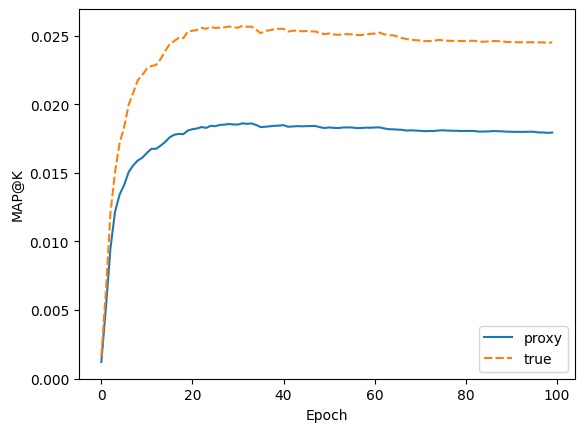

In [29]:
train_losses, proxy_losses, true_losses = res[0]
df = pd.DataFrame({'proxy': proxy_losses, 'true': true_losses})
sns.lineplot(data=df)
plt.xlabel("Epoch")
plt.ylabel("MAP@K")


Text(0, 0.5, 'MAP@K')

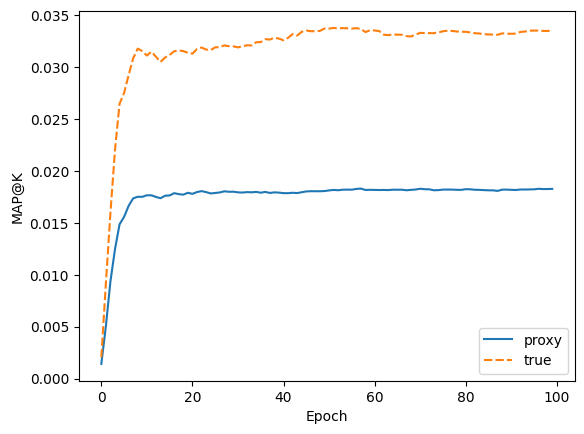

In [30]:
train_losses, proxy_losses, true_losses = res[1]
df = pd.DataFrame({'proxy': proxy_losses, 'true': true_losses})
sns.lineplot(data=df)
plt.xlabel("Epoch")
plt.ylabel("MAP@K")


Text(0, 0.5, 'MAP@K')

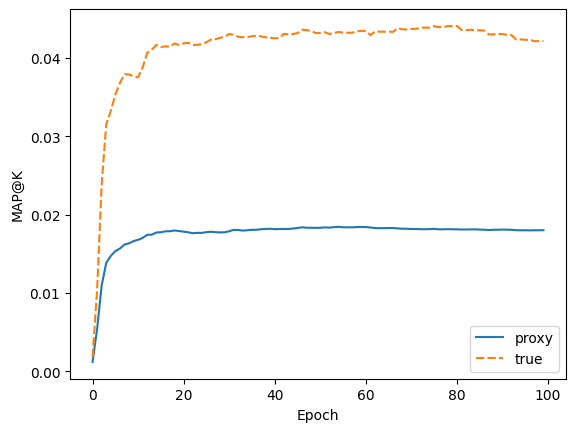

In [31]:
train_losses, proxy_losses, true_losses = res[2]
df = pd.DataFrame({'proxy': proxy_losses, 'true': true_losses})
sns.lineplot(data=df)
plt.xlabel("Epoch")
plt.ylabel("MAP@K")


Text(0, 0.5, 'MAP@K')

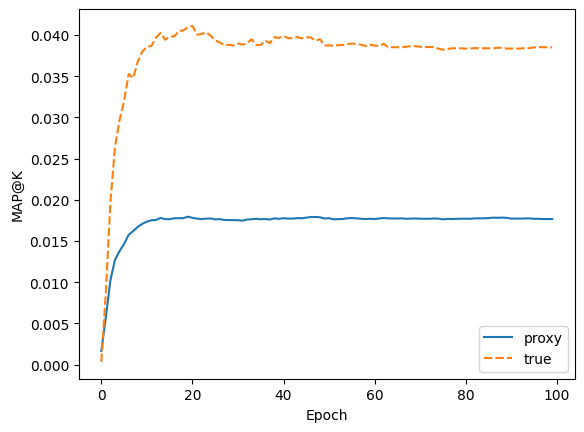

In [32]:
train_losses, proxy_losses, true_losses = res[3]
df = pd.DataFrame({'proxy': proxy_losses, 'true': true_losses})
sns.lineplot(data=df)
plt.xlabel("Epoch")
plt.ylabel("MAP@K")
